In [1]:
%%capture
#mutes cell output
#%pylab inline
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from glob import glob
from IPython.display import display
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler

import os
import SFG2D
import pandas as pd
import seaborn as sns
import ipywidgets as ipyw

plt.style.use('seaborn-notebook')
sns.set_style("white")
sns.set_style("ticks")
#sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Import Data

## Select Data

In [2]:
# Global variables hold data
ffolder = '/home/malte/deiseroth/MeasurmentData/sudipta/2016/08/29/'
ffiles = glob(ffolder + '/*.dat')
ffiles = [ x for x in ffiles if "AVG" not in x ]

fnames = [os.path.split(ffile)[1] for ffile in ffiles]

ir = None
pump = None
base = None
ts0 = None
ts0u = None # Unnormalized TimeSeries

# Watchdog to monitor ffolder
class MyHandler(FileSystemEventHandler):
    def on_modified(self, event):
        global ffiles, fnames
        ffiles = glob(ffolder + '/*.dat')
        ffiles = [ x for x in ffiles if "AVG" not in x ]
        fnames = [os.path.split(ffile)[1] for ffile in ffiles]
        w_ir_fpath.options = fnames

ffolder_observer = Observer()
event_handler = MyHandler()
ffolder_observer.schedule(event_handler, ffolder, recursive=False)
ffolder_observer.start()
    
# register widgets
w_ir_fpath = ipyw.Select(options=fnames, description='IR Profile')
w_ir_fbase = ipyw.Select(description='IR Base')
w_ir_spec = ipyw.Select(
    options = ["All", "spec_0", "spec_1", "spec_2"], 
    description="Spectrum", value="spec_1"
)
w_ir_sub_base = ipyw.ToggleButton(
    description='Sub Baseline',
    value=False
)

w_pump_fpath = ipyw.Select(description='Pump SFG')
w_pump_fbase = ipyw.Select(description='Pump Base')
w_pump_spec = ipyw.Select(
    options = ["All", "spec_0", "spec_1", "spec_2"], 
    description="Spectrum", value="spec_1"
)
w_pump_ppdelay = ipyw.SelectionSlider(continuous_update=False)

w_ts0_fpath = ipyw.Select(description='Pump Probe')
w_ts0_pumped = ipyw.Dropdown(
    options = ["spec_0", "spec_1", "spec_2"], 
    description="pumped", value="spec_0"
)
w_ts0_probed = ipyw.Dropdown(
    options = ["spec_0", "spec_1", "spec_2"], 
    description="probed", value="spec_1"
)
w_ts0_sub_base = ipyw.ToggleButton(description='Sub Baseline', value=False)
w_ts0_normalize = ipyw.ToggleButton(description='Normalize', value=False)
w_ts0_ppdelay = ipyw.SelectionSlider(continuous_update=False)
w_ts0_ppdelay_childs = [ ipyw.SelectionSlider(continuous_update=False)
                  for i in range(4)
]

w_fbase = ipyw.Select(description='Baseline')

# observer functions
def pump_plot_update(change):
    pump_plot(w_pump_spec.value, w_pump_ppdelay.value)  
    
def pump_probe_plot_update(change):
    pump_probe_plot(w_ts0_ppdelay.value)
    
def ts0_pumped_update(change):
    ts0._pumped = w_ts0_pumped.value
    if isinstance(ts0._df.get("bleach"), pd.core.series.Series):
        ts0.df.drop('bleach', axis=1, inplace=True)
    
def ts0_proped_update(change):
    ts0._probed = w_ts0_probed.value
    if isinstance(ts0._df.get("bleach"), pd.core.series.Series):
        ts0.df.drop('bleach', axis=1, inplace=True)

# link widget properties
import traitlets
_l_fpath = {}
for _name, _w in (('ir_fbase',w_ir_fbase), 
                  ('pump_fpath',w_pump_fpath), ('pump_fbase', w_pump_fbase), 
                  ('ts0_fpath', w_ts0_fpath), ('ts0_fbase', w_fbase)):
     _l_fpath[_name] = (traitlets.dlink((w_ir_fpath, 'options'), (_w, 'options')))
    
_l_ts0_ppdelay_childs = []
for _w in w_ts0_ppdelay_childs:
    _l_ts0_ppdelay_childs.append(traitlets.dlink((w_ts0_ppdelay, 'options'),(_w, 'options')))
 
# Default Widget values
if '2016/08/01' in ffolder:
    w_ir_fpath.value = '09_sc_quartz_w674_gcm_e10s_ssp_pu0_pr1_vis1_gal1_chop1_purge1.dat'
    w_ir_fbase.value = '08_sp_gold_w674_gcm_e1s_ppp_pu0_pr0_vis1_gal1_chop1_purge1.dat'
    w_pump_fpath.value ='04_ts_quartz_w674_gcm_e10s_ssp_pu1_pr0_vis1_gal0_chop0_purge1.dat'
    w_pump_fbase.value = '05_sc_quartz_w674_gcm_e10s_ssp_pu0_pr1_vis1_gal0_chop0_purge1.dat'
    w_ts0_fpath.value = '15_ts_na2s04-002_w674_gcm_e10m_ssp_pu1_pr1_vis1_gal1_chop1_purge1_chil10.dat'
    w_fbase.value = '11_sc_quartz_w674_gcm_e10m_ssp_pu0_pr0_vis1_gal1_chop1_purge1.dat'
    
# widget observers
w_pump_fpath.observe(pump_plot_update, names="value")
w_ts0_fpath.observe(pump_probe_plot_update, names="value")
w_ts0_pumped.observe(ts0_pumped_update, names="value")
w_ts0_probed.observe(ts0_proped_update, names="value")

## IR Profile

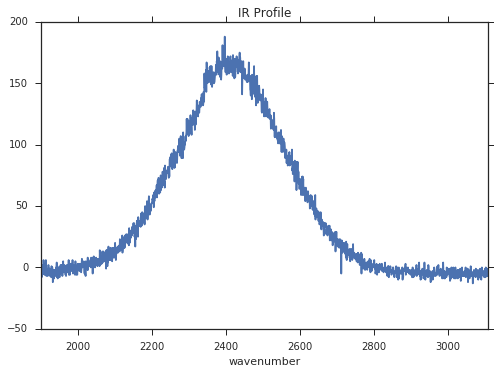

In [3]:
# These functions have strings as input,
# Then there form becomes unclear
# and at the end they need to return a spectrum  object with
# well defined form.
def get_ir(fpath, fbase, sub_base, spec):
    global ir
    ir = SFG2D.io.veronica.read_auto(ffolder + fpath)
    if sub_base:
        ir.base = SFG2D.io.veronica.read_auto(ffolder + fbase).med
        ir.sub_base(inplace=True)
    if spec is "All":
        ir.df.plot()
    else:
        ir.med[spec].plot()
    plt.title("IR Profile")
    plt.draw()

w_ir = ipyw.interactive(get_ir, fpath=w_ir_fpath, fbase=w_ir_fbase, 
                        sub_base=w_ir_sub_base, spec=w_ir_spec )
display(w_ir)
plt.show()

## Pump Profile

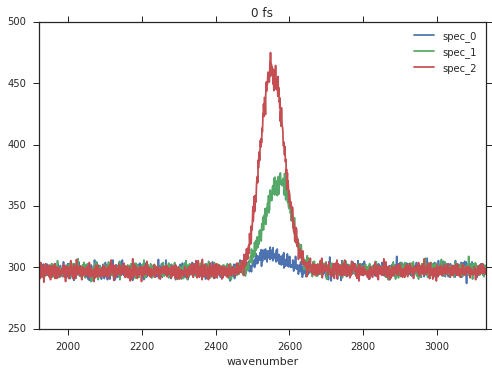

In [4]:
def get_pump(fpath):
    global pump, w_pump_ppdelay
    pump = SFG2D.io.veronica.read_auto(ffolder + fpath)
    
    if isinstance(pump, SFG2D.core.scan.Scan):
        raise NotImplementedError
    
    if isinstance(pump, SFG2D.core.scan.TimeScan):
        w_pump_ppdelay.options = list(pump.pp_delays)
        w_pump_ppdelay.value = 0

def pump_plot(spec, pp_delay):
    if isinstance(pump, SFG2D.core.scan.TimeScan):
    
        if spec == "All":
            pump.med.ix[pp_delay].plot()
        else:
            pump.med.ix[pp_delay, spec].plot()
        plt.title('%i fs'%pp_delay)
        plt.draw()

    
    
w_pump = ipyw.interactive(get_pump, fpath = w_pump_fpath)
display(w_pump)

w_pump_plot = ipyw.interactive(pump_plot, spec=w_pump_spec, pp_delay=w_pump_ppdelay)
#w_pump_fpath.observe(w_pump, names='value')

display(w_pump_plot)
plt.show()

## Pump-Probe Data

## Baseline for Pump-Probe Data

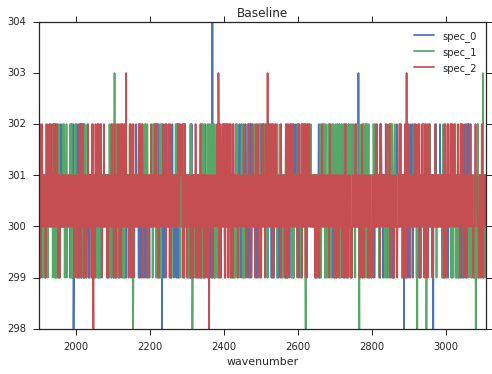

In [5]:
def get_base(fbase):
    global base
    base = SFG2D.io.veronica.read_auto(ffolder + fbase)
    if isinstance(base, SFG2D.core.scan.TimeScan):
        raise NotImplementedError
    base.med.plot()
    plt.title("Baseline")
    plt.draw()


w_base = ipyw.interactive(get_base, fbase = w_fbase)
display(w_base)
plt.show()

In [6]:
%%capture
def get_pump_probe(fpath, sub_base=False, normalize=False):
    global ts0, ts0u
    ts0 = SFG2D.io.veronica.read_auto(ffolder + fpath)
    if sub_base:
        ts0.base = base.med
        ts0.sub_base(inplace=True)
    if w_ir_spec.value is "All":
        ts0.norm = ir.med
    else:
        ts0.norm = ir.med[w_ir_spec.value]
    ts0u = ts0.__deepcopy__()
    if normalize:
        ts0.normalize(inplace=True)
    if isinstance(ts0, SFG2D.core.scan.TimeScan):
        w_ts0_ppdelay.options=list(ts0.pp_delays)
        w_ts0_ppdelay.value=0
    
    #if isinstance(ts0, SFG2D.core.scan.TimeScan):
    #    raise NotImplementedError
    
    
def ts0_pump_update(*args):
    #global ts0
    ts0._pumped = w_ts0_pumped.value
    ts0u._pumped = w_ts0_pumped.value
    
def ts0_probe_update(*args):
    #global ts0
    ts0u._probed = w_ts0_probed.value
    ts0._probed = w_ts0_probed.value
    
def pump_probe_sum_plot(*args):
    ax = axes_pump_probe_get[1]
    ax.set_title('jajaja')
    if isinstance(ts0u, SFG2D.core.scan.TimeScan):
        [SFG2D.plotting.ts.sum_of_spectra(ts0u, spec, ax) for spec in ('spec_0', 'spec_1', 'spec_2')]
    ax.set_title("Sum of Spectra")
    #display(fig_pump_probe_get)

def pump_probe_plot(pp_delay):
    ax = axes_pump_probe_get[0]
    ax.clear()
    
    if isinstance(ts0u, SFG2D.core.scan.TimeScan):
        ts0u.med.ix[pp_delay].plot(ax=ax)
        ax.set_title("%i fs"%pp_delay)
        #plt.ylim(-0.002, 0.015) # get this from data
        #plt.xlim(2100, 2800) # get this from ir profile
    fig_pump_probe_get.tight_layout()
    display(fig_pump_probe_get)

w_ts0_pumped.observe(ts0_pump_update, 'value')
w_ts0_probed.observe(ts0_proped_update, 'value')
    
fig_pump_probe_get, axes_pump_probe_get = plt.subplots(1,2, figsize=(16,6))

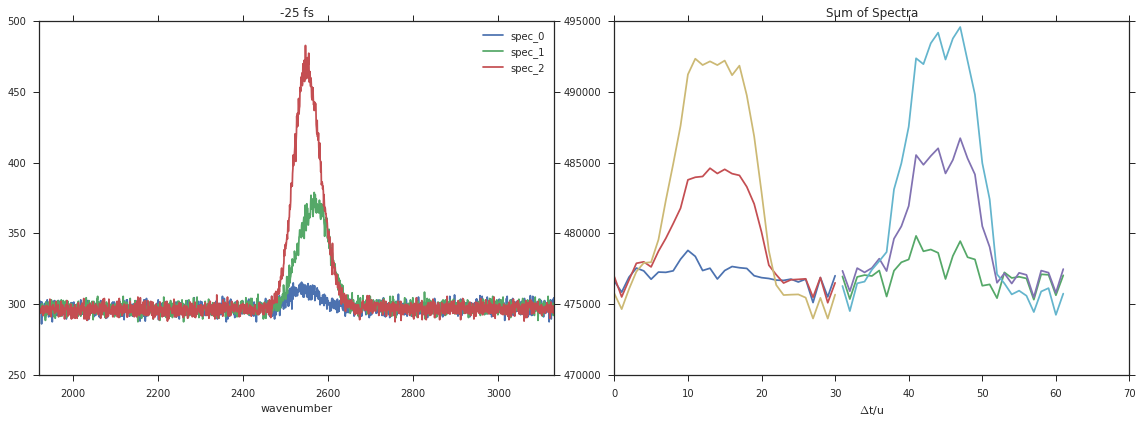

In [7]:
w_ts0 = ipyw.interactive(get_pump_probe, fpath=w_ts0_fpath, sub_base=w_ts0_sub_base, normalize=w_ts0_normalize)

w_ts0_plot = ipyw.interactive(pump_probe_plot, pp_delay=w_ts0_ppdelay)
display(w_ts0, w_ts0_pumped, w_ts0_probed, w_ts0_plot)
pump_probe_sum_plot()

## Normalize Spectra

In [8]:
%%capture
fig_norm, ax_norm = plt.subplots(1,2, figsize=(12,6))
ax_norm[0].set_title("Unnormalized")
ax_norm[1].set_title("Normalized")
#ax_norm[1].set_ylim(-0.002, 0.015)
ts0u.pumped.ix[w_ts0_ppdelay.value].plot(ax = ax_norm[0], label="pumped")
ts0u.probed.ix[w_ts0_ppdelay.value].plot(ax = ax_norm[0], label="probed")

ts0.pumped.ix[w_ts0_ppdelay.value].plot(ax = ax_norm[1], label = "pumped")
ts0.probed.ix[w_ts0_ppdelay.value].plot(ax = ax_norm[1], label = "probed")

ax_norm[0].legend()
fig_norm.tight_layout()


def plot_norm_update(pp_delay):
    ax_norm[0].lines[0].set_ydata(ts0u.pumped.ix[pp_delay])
    ax_norm[0].lines[1].set_ydata(ts0u.probed.ix[pp_delay])

    ax_norm[1].lines[0].set_ydata(ts0.pumped.ix[pp_delay])
    ax_norm[1].lines[1].set_ydata(ts0.probed.ix[pp_delay])
       
    display(fig_norm)

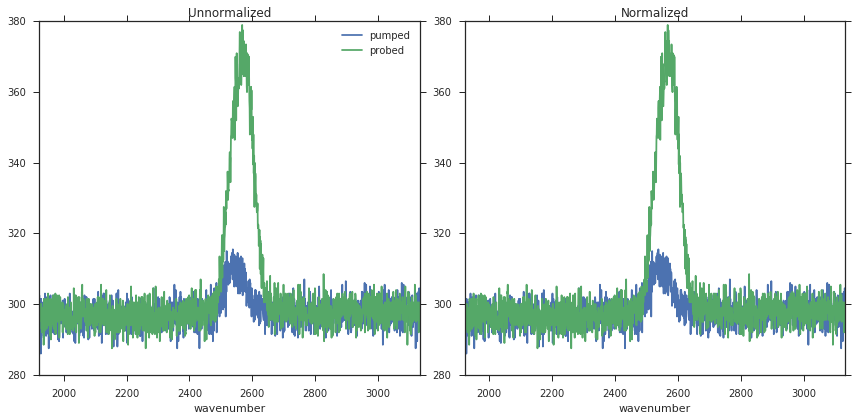

In [9]:
ipyw.interact(plot_norm_update, pp_delay=w_ts0_ppdelay_childs[0])

# Spectra Over Time

In [10]:
%%capture
roi = slice(2200,2800)

def plot_compare_update(pp_delay):
    for i in range(ts0.df['spec_0'].shape[1]):
        data = ts0.df.loc[w_ts0_ppdelay_childs[1].value, "spec_0"][roi].iloc[:,i]
        ax_compare[0].lines[i].set_ydata(data)
        data = ts0.df.loc[w_ts0_ppdelay_childs[1].value, "spec_1"][roi].iloc[:,i]
        ax_compare[1].lines[i].set_ydata(data)
    
    display(fig_compare)
    

fig_compare, ax_compare = plt.subplots(1, 2, sharey=True, figsize=(16,6))
ts0.df.loc[w_ts0_ppdelay_childs[1].value, "spec_0"][roi].plot(ax=ax_compare[0])        
ts0.df.loc[w_ts0_ppdelay_childs[1].value, "spec_1"][roi].plot(ax=ax_compare[1])
for ax, title in zip(ax_compare, ('spec_0', 'spec_1')):
    ax.set_title(title)
    for i in range(len(ax.lines)):
        ax.lines[i].set_label('run %i'%i)
    ax.legend()
#plt.ylim(-0.002, 0.017)

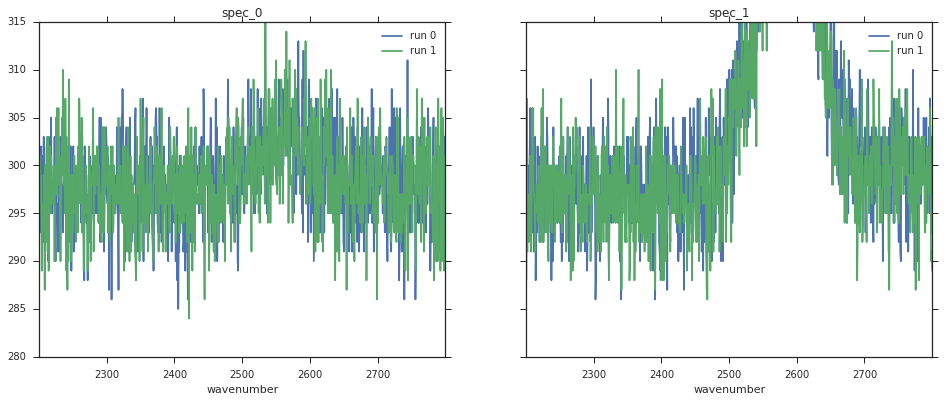

In [11]:
w_f0 = ipyw.interact(plot_compare_update, pp_delay=w_ts0_ppdelay_childs[1])
#display(w_f0)

## Smoothed

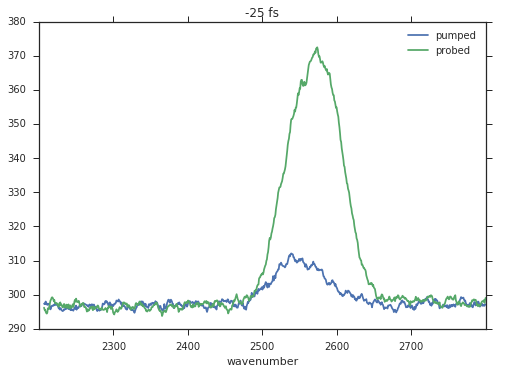

In [18]:
#pp_slider3 = ipyw.SelectionSlider(options=list(ts0.pp_delays), value=0, continuous_update=False)
roi = slice(2200,2800) # get this from the pump
def p3(pp_delay):
    ts0.pumped.loc[pp_delay][roi].rolling(10).mean().plot(label="pumped")
    ts0.probed.loc[pp_delay][roi].rolling(10).mean().plot(label="probed")
    #plt.ylim(0.001, 0.015)
    plt.title(str(pp_delay) + " fs")
    plt.legend()
    #plt.grid()

w_p3 = ipyw.interactive(p3, pp_delay=w_ts0_ppdelay_childs[2])
display(w_p3)
plt.show()

# Bleach Trace

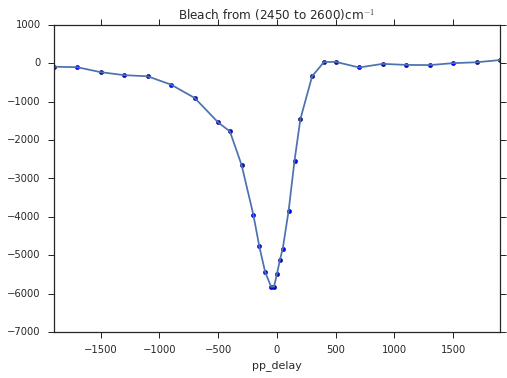

In [19]:
roi_slider_range = int(ts0.df.index.levels[1].min()), int(ts0.df.index.levels[1].max())
#roi_slider_range = 0, 800
roi_slider = ipyw.IntRangeSlider(
    value = (2450, 2600),
    min = roi_slider_range[0],
    max = roi_slider_range[1],
    continuous_update=False
)

#roi = slice(2450,2600)

def plot_bleach_trace(roi):
    tss = ts0.bleach.unstack(0)
    tss = tss[(tss.index > roi[0]) & (tss.index < roi[1])].sum()

    tss.plot()
    plt.scatter(tss.index, tss)
    plt.title(r"Bleach from (%i to %i)cm$^{-1}$"%(roi[0], roi[1]))
    
ipyw.interact(plot_bleach_trace, roi=roi_slider)
plt.show()